In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path

In [3]:
# Determine the notebook’s current directory
current = Path().resolve()

# Traverse upward until we find a directory named "MOTIF"
for p in [current] + list(current.parents):
    if p.name == "Motif":
        os.chdir(p)
        print("Changed working directory to Motif root:", p)
        break
else:
    raise FileNotFoundError("Could not locate a parent directory named 'Motif'")

Changed working directory to Motif root: /Users/juliamarlene/Documents/GitHub/Motif


In [12]:
# Load grid search results
df = pd.read_csv('results/evaluation_grid_search/grid_search_results.tsv', sep="\t")
df.drop('intersec_entrez', axis=1)

,should_normalize,should_group_by_gene,method,alpha,beta,p_value
0,False,False,mean,NaN,NaN,0.328405
1,False,False,freq,10.0,2.0,0.319980


In [13]:
# Find the Top 10 parameter settings by lowest p_value
top10 = df.nsmallest(10, 'p_value')
print("Top 10 parameter settings by p_value:")
print(top10)

Top 10 parameter settings by p_value:
   should_normalize  should_group_by_gene method  alpha  beta   p_value  \
1             False                 False   freq   10.0   2.0  0.319980   
0             False                 False   mean    NaN   NaN  0.328405   

                                     intersec_entrez  
1  794,1602,2679,4925,5217,5251,5318,5476,5775,58...  
0  794,1602,3848,4925,5217,5251,5318,5476,5775,58...  


In [30]:
top10 = df[(df['method'] == 'frequency')].nsmallest(10, 'p_value')
print("Top 10 parameter settings by p_value:")
print(top10)


Top 10 parameter settings by p_value:
Empty DataFrame
Columns: [should_normalize, should_group_by_gene, method, alpha, beta, p_value, intersec_entrez]
Index: []


In [29]:
# Filter for relevant rows including alpha=10 and beta=2
subset = df[
    (df['alpha'] == 10) & 
    (df['beta'] == 2)
]

print(subset)
# Define combinations to test
combinations = [
    (False, False),
    (False, True),
    (True, False),
    (True, True)
]

# Collect best p_value per method and setting combination
results = []

for method in df['method'].unique():
    for group_by, normalize in combinations:
        filtered = subset[
            (subset['method'] == method) &
            (subset['should_group_by_gene'] == group_by) &
            (subset['should_normalize'] == normalize)
        ]
        if not filtered.empty:
            best_row = filtered.loc[filtered['p_value'].idxmin()]
            results.append(best_row)

# Convert to DataFrame
best_combinations = pd.DataFrame(results)

# Optional: sort and display
best_combinations = best_combinations.sort_values(by=['method', 'should_group_by_gene', 'should_normalize'])
print(best_combinations)



   should_normalize  should_group_by_gene method  alpha  beta  p_value  \
1             False                 False   freq   10.0   2.0  0.31998   

                                     intersec_entrez  
1  794,1602,2679,4925,5217,5251,5318,5476,5775,58...  
   should_normalize  should_group_by_gene method  alpha  beta  p_value  \
1             False                 False   freq   10.0   2.0  0.31998   

                                     intersec_entrez  
1  794,1602,2679,4925,5217,5251,5318,5476,5775,58...  


In [28]:
import pandas as pd

# Filter for the main criteria
subset = df[
    (df['alpha'] == 10) &
    (df['beta'] == 2)
]

# Define all combinations
methods = df['method'].unique()
combinations = [(g, n) for g in [False, True] for n in [False, True]]

# Collect results
results = []

for method in methods:
    for group_by, normalize in combinations:
        filtered = subset[
            (subset['method'] == method) &
            (subset['should_group_by_gene'] == group_by) &
            (subset['should_normalize'] == normalize)
        ]
        if not filtered.empty:
            best_row = filtered.loc[filtered['p_value'].idxmin()]
            results.append(best_row)
        else:
            # Append placeholder row with NaNs if no result
            results.append(pd.Series({
                'method': method,
                'should_group_by_gene': group_by,
                'should_normalize': normalize,
                'alpha': 10,
                'beta': 2,
                'p_value': float('nan')
            }))

# Assemble final DataFrame
best_combinations = pd.DataFrame(results)

# Reorder columns
best_combinations = best_combinations[
    ['method', 'should_group_by_gene', 'should_normalize', 'alpha', 'beta', 'p_value']
]

# Sort for clarity
best_combinations = best_combinations.sort_values(by=['method', 'should_group_by_gene', 'should_normalize'])

print(best_combinations)


          method  should_group_by_gene  should_normalize  alpha  beta  p_value
1           freq                 False             False   10.0   2.0  0.31998
Unnamed 4   freq                 False              True   10.0   2.0      NaN
Unnamed 5   freq                  True             False   10.0   2.0      NaN
Unnamed 6   freq                  True              True   10.0   2.0      NaN
Unnamed 0   mean                 False             False   10.0   2.0      NaN
Unnamed 1   mean                 False              True   10.0   2.0      NaN
Unnamed 2   mean                  True             False   10.0   2.0      NaN
Unnamed 3   mean                  True              True   10.0   2.0      NaN


In [25]:
# Find the Worst 10 parameter settings by lowest p_value
worst10 = df.nlargest(10, 'p_value')
print("Worst 10 parameter settings by p_value:")
print(worst10)

Worst 10 parameter settings by p_value:
   should_normalize  should_group_by_gene method  alpha  beta   p_value  \
0             False                 False   mean    NaN   NaN  0.328405   
1             False                 False   freq   10.0   2.0  0.319980   

                                     intersec_entrez  
0  794,1602,3848,4925,5217,5251,5318,5476,5775,58...  
1  794,1602,2679,4925,5217,5251,5318,5476,5775,58...  


In [19]:
# Main effects: mean p_value by each factor, in long form
effects_list = []
for factor in [
    'should_normalize',
    'should_group_by_gene',
    'method',
    'alpha',
    'beta'
]:
    means = (
        df
        .groupby(factor)['p_value']
        .mean()
        .reset_index(name='mean_p_value')
    )
    means['factor'] = factor
    means.rename(columns={factor: 'level'}, inplace=True)
    effects_list.append(means)

effects_df = pd.concat(effects_list, ignore_index=True)
print("\n=== Mean p_value by factor level ===")
print(effects_df.to_string(index=False))


=== Mean p_value by factor level ===
level  mean_p_value               factor
False      0.324192     should_normalize
False      0.324192 should_group_by_gene
 freq      0.319980               method
 mean      0.328405               method
 10.0      0.319980                alpha
  2.0      0.319980                 beta


In [20]:

# α–β interaction: pivot table of mean p_value
alpha_beta = df.pivot_table(
    index='alpha', 
    columns='beta', 
    values='p_value', 
    aggfunc='mean'
)
print("\nMean p_value for each α–β combination:")
print(alpha_beta)


Mean p_value for each α–β combination:
beta       2.0
alpha         
10.0   0.31998


<Figure size 800x500 with 0 Axes>

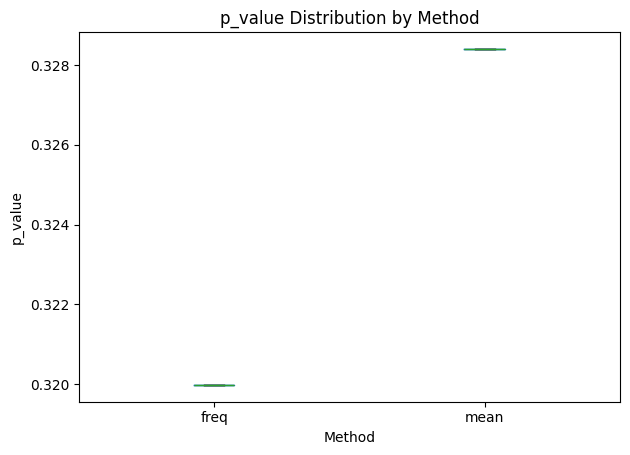

In [21]:

# Visualize: boxplot of p_value by aggregation method
plt.figure(figsize=(8,5))
df.boxplot(column='p_value', by='method', grid=False)
plt.title('p_value Distribution by Method')
plt.suptitle('')  # remove the default “Boxplot grouped by method” title
plt.xlabel('Method')
plt.ylabel('p_value')
plt.tight_layout()
plt.show()


In [23]:
df.groupby('method')['p_value'].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
freq,1.0,0.319980,NaN,0.319980,0.319980,0.319980,0.319980,0.319980
mean,1.0,0.328405,NaN,0.328405,0.328405,0.328405,0.328405,0.328405


/var/folders/_m/p6dshx3x4gg4mjfxf0t9_44h0000gn/T/ipykernel_12169/913406450.py:14: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(heatmap_data.values, aspect='auto')
/var/folders/_m/p6dshx3x4gg4mjfxf0t9_44h0000gn/T/ipykernel_12169/913406450.py:14: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(heatmap_data.values, aspect='auto')


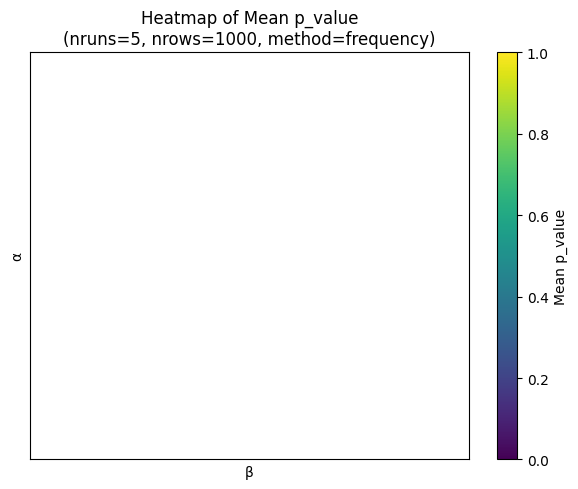

In [24]:
# Filter for nruns=5, nrows=1000, method=frequency
sub = df[df['method'] == 'frequency']

# Pivot to get mean p_value for each α–β combination
heatmap_data = sub.pivot_table(
    index='alpha',
    columns='beta',
    values='p_value',
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.imshow(heatmap_data.values, aspect='auto')
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
plt.xlabel('β')
plt.ylabel('α')
plt.title('Heatmap of Mean p_value\n(nruns=5, nrows=1000, method=frequency)')
cbar = plt.colorbar(label='Mean p_value', orientation='vertical')
plt.tight_layout()
plt.show()


/var/folders/_m/p6dshx3x4gg4mjfxf0t9_44h0000gn/T/ipykernel_7942/4164425268.py:16: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(heatmap_data.values, aspect='auto')
/var/folders/_m/p6dshx3x4gg4mjfxf0t9_44h0000gn/T/ipykernel_7942/4164425268.py:16: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(heatmap_data.values, aspect='auto')


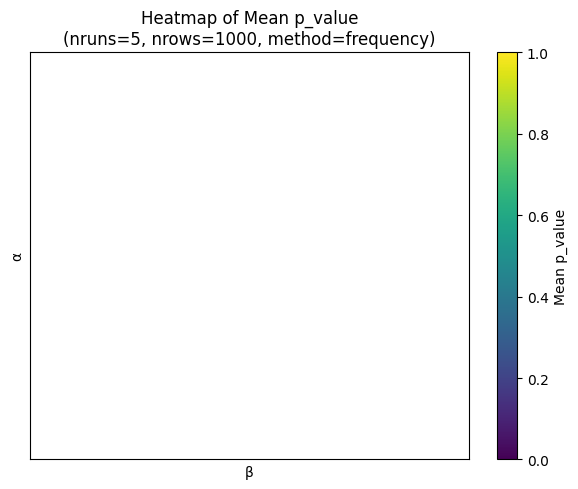

In [27]:
# Filter for nruns=5, nrows=1000, method=frequency
sub = df[(df['nruns'] == 5) & 
         (df['nrows'] == 10000000) & 
         (df['method'] == 'frequency')]

# Pivot to get mean p_value for each α–β combination
heatmap_data = sub.pivot_table(
    index='alpha',
    columns='beta',
    values='p_value',
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.imshow(heatmap_data.values, aspect='auto')
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
plt.xlabel('β')
plt.ylabel('α')
plt.title('Heatmap of Mean p_value\n(nruns=5, nrows=1000, method=frequency)')
cbar = plt.colorbar(label='Mean p_value', orientation='vertical')
plt.tight_layout()
plt.show()